# Horseshoe Prior

In this example, we will use the Horseshoe Prior (Carvalho et al., 2009) to model a large number of variables, with only a few slopes being significantly different from zero. 

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd

Here is what we did:

* We defined an intercept.
* We defined a vector of 50 betas, 5 of which were drawn from a normal(5,1) distribution, and then assigned a random sign.
* We created the design matrix with normal(0,1) entries and set $\sigma$ to 1.
* We calculated the deterministic means $\mu$ using the intercept and the design matrix multiplied by the betas.
* We simulated 100 response variables (observations) from a normal distribution with mean $\mu$ and standard deviation $\sigma$.

Next, we proceeded with the Bayesian estimation of the model. We proposed the horseshoe prior, for which the following parameters were calculated:

$$\mu_i = \alpha + \beta_1 x_{1i} + \beta_2 x_{2i} + ... + \beta_p x_{pi}$$

$$y_i \sim N(\mu_i, \sigma^2)$$

$$\alpha \sim N(0,1)$$

$$\beta_j \sim N(0,\lambda_j^2 \tau^2)$$

$$\lambda_j \sim C^+(0,1)$$

$$\tau \sim T^+(df=3)$$

$$\sigma^2 \sim N^+(0,1)$$

In [2]:
D = 50
D0 = 5

SEED = 123456789 # for reproducibility

rng = np.random.default_rng(SEED)

INTERCEPT = rng.uniform(-3, 3) # simulate an intercept

COEF = np.zeros(D)
# Simulate the slopes for significant variables
COEF[:D0] = rng.choice([-1, 1], size=D0) * rng.normal(5, 1, size=D0)

N = 100
X = rng.normal(size=(N, D))
SIGMA = 1.0

# Simulate the data
y = INTERCEPT + X.dot(COEF) + rng.normal(0, SIGMA, size=N)

Here we create the dataframe and the term name for the set of variables, to define the formula. 

In [3]:
df = pd.DataFrame(X)
df.columns = [f"x{i}" for i in range(X.shape[1])]
df["y"] = y

In [4]:
term_name = "c(" + ", ".join([f"x{i}" for i in range(X.shape[1])]) + ")"
formula = f"y ~ {term_name}"
formula

'y ~ c(x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27, x28, x29, x30, x31, x32, x33, x34, x35, x36, x37, x38, x39, x40, x41, x42, x43, x44, x45, x46, x47, x48, x49)'

Finally, we call the Horseshoe prior and create the model

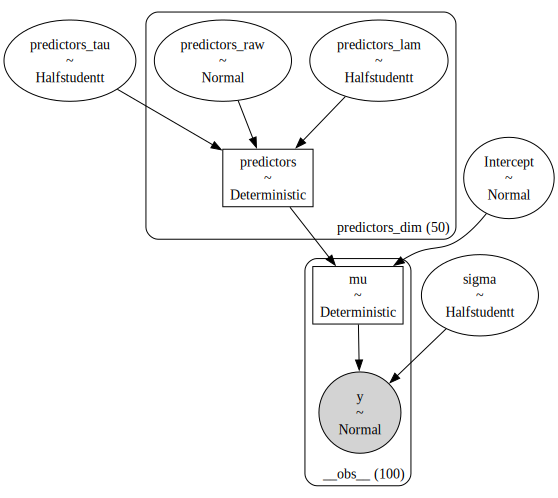

In [5]:
priors = {
    term_name: bmb.Prior("Horseshoe"),
}
model = bmb.Model(formula, df, priors=priors)
model.set_alias({term_name: "predictors"})

model.build()
model.graph()

In [6]:
idata = model.fit(target_accept=0.95, chains=2)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, predictors_tau, predictors_lam, predictors_raw]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 32 seconds.
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


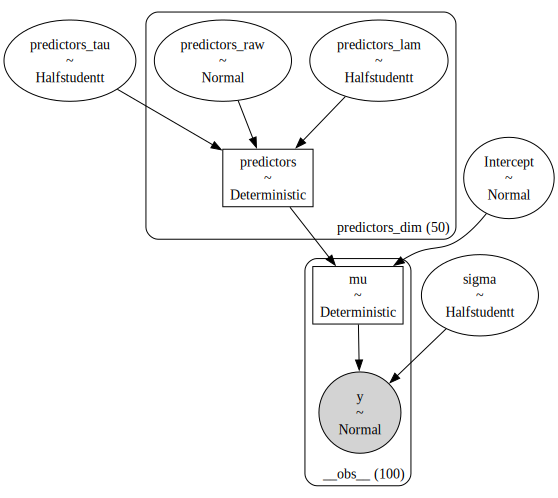

In [7]:
priors = {
    term_name: bmb.Prior("Horseshoe", tau_nu = 3, lam_nu = 3),
}
model = bmb.Model(formula, df, priors=priors)
model.set_alias({term_name: "predictors"})

model.build()
model.graph()

In [8]:
idata = model.fit(target_accept=0.97)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, predictors_tau, predictors_lam, predictors_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


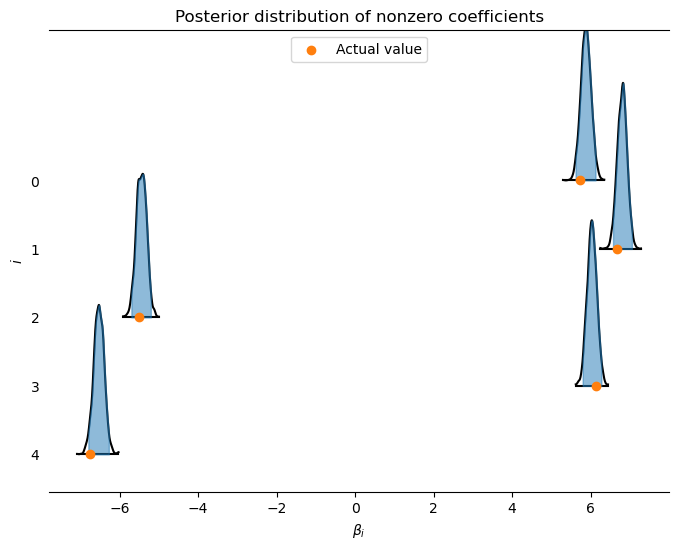

In [9]:
ax, = az.plot_forest(
    idata, 
    var_names=["predictors"], 
    coords={"predictors_dim": range(D0)},
    kind='ridgeplot',
    ridgeplot_truncate=False, 
    ridgeplot_alpha=0.5,
    hdi_prob=0.95, 
    combined=True,
    figsize=(8, 6)
)
ax.scatter(COEF[:D0][::-1], ax.get_yticks(), c='C1', label="Actual value");
ax.set_xlabel(r"$\beta_i$");
ax.set_ylim(bottom=None, top=1.55 * ax.get_yticks().max())
ax.set_yticklabels(range(D0)[::-1]);
ax.set_ylabel(r"$i$");
ax.legend(loc='upper center');
ax.set_title("Posterior distribution of nonzero coefficients");

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Feb 18 2026

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.6.0

numpy : 2.3.3
pandas: 2.3.3
bambi : 0.16.1.dev36+ge11a3bf70.d20260218
arviz : 0.22.0

Watermark: 2.5.0

